In [12]:
# Reload all modules (except those excluded)
%load_ext autoreload
%autoreload 2 

import numpy as np
import matplotlib.pyplot as plt

import stim
print(stim.__version__)
import pymatching
print(pymatching.__version__)

from circDist3RepetitionCode import generate_stim_circuit
from Util_Stim import count_logical_errors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.16.dev0
2.3.1


<img src="google_07_fig1.png">

Task: follow up exercises for lecture 07

Test 1: Generating circuit with p=0.001 for all errors
stim.Circuit('''
    R 0 1 2 3 4
    X_ERROR(0.005) 0 1 2 3 4
    TICK
    CX 0 1 2 3
    DEPOLARIZE2(0.001) 0 1 2 3
    DEPOLARIZE1(0.001) 4
    TICK
    CX 2 1 4 3
    DEPOLARIZE1(0.001) 0
    DEPOLARIZE2(0.001) 2 1 4 3
    TICK
    X_ERROR(0.001) 1 3
    M 1 3
    DEPOLARIZE1(0.001) 0 2 4
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]
    REPEAT 3 {
        R 1 3
        X_ERROR(0.005) 1 3
        DEPOLARIZE1(0.001) 0 2 4
        TICK
        CX 0 1 2 3
        DEPOLARIZE2(0.001) 0 1 2 3
        DEPOLARIZE1(0.001) 4
        TICK
        CX 2 1 4 3
        DEPOLARIZE1(0.001) 0
        DEPOLARIZE2(0.001) 2 1 4 3
        TICK
        X_ERROR(0.001) 1 3
        M 1 3
        DEPOLARIZE1(0.001) 0 2 4
        SHIFT_COORDS(0, 1)
        DETECTOR(1, 0) rec[-2] rec[-4]
        DETECTOR(3, 0) rec[-1] rec[-3]
    }
    X_ERROR(0.001) 0 2 4
    M 0 2 4
    SHIFT_COORDS(0, 1)
    DETECTOR(1, 0) rec[-2] rec[-3] rec[-5]
    DETECTOR(3, 

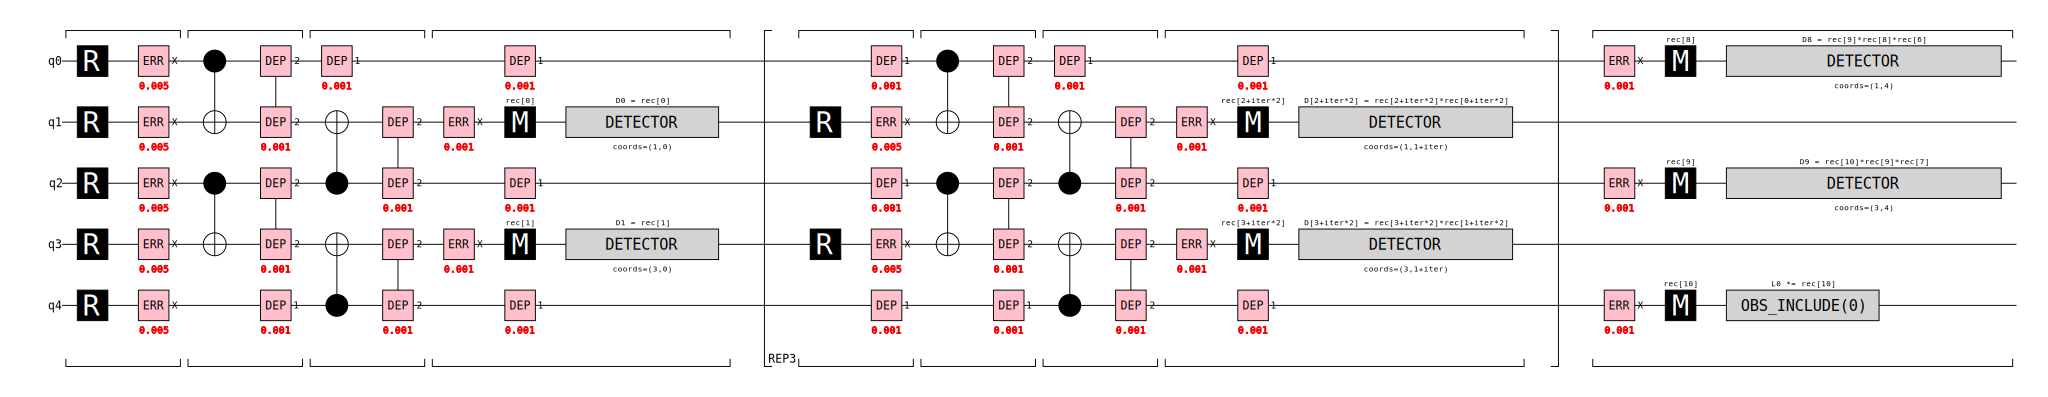

In [13]:
print("Test 1: Generating circuit with p=0.001 for all errors")
circDef1 = generate_stim_circuit(
        num_repeat=3,
        ex_reset=0.005,
        pd_cx=0.001,
        pd_idle=0.001,
        ex_read=0.001
    )
circuit1 = stim.Circuit(circDef1)
print(repr(circuit1))
circuit1.diagram('timeline-svg')

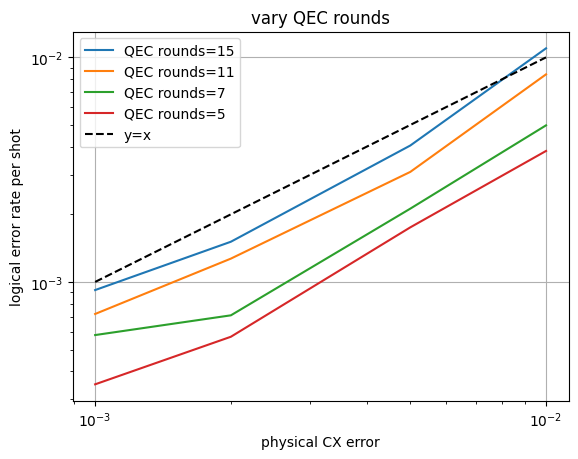

In [14]:
fig, ax = plt.subplots()
ax.set(title='vary QEC rounds')
num_shots = 100_000
for k in [15,11,7,5]:
    xs = [];   ys = []
    for x in [0.001, 0.002, 0.005, 0.01]:
        circDef = generate_stim_circuit(  num_repeat=k, pd_cx=x, ex_read=1e-3)
        circuit = stim.Circuit(circDef)
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(x)
        ys.append(num_errors_sampled / num_shots)
    ax.plot(xs, ys, label=f"QEC rounds={k}")
ax.plot([1e-3,1e-2],[1e-3,1e-2],'k--',label='y=x')
ax.set(xscale='log', yscale='log', xlabel="physical CX error", ylabel="logical error rate per shot")
ax.legend(); ax.grid()

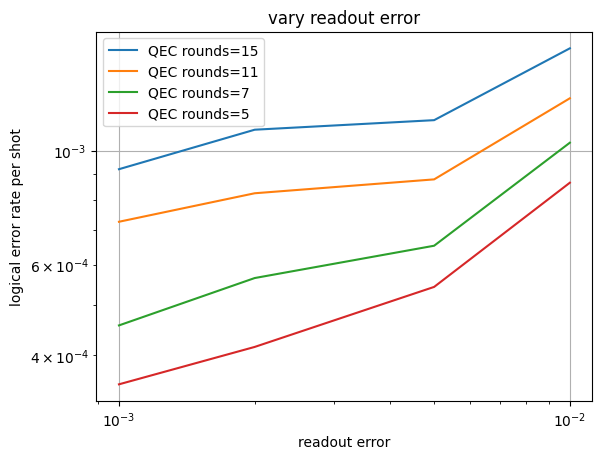

In [15]:
fig, ax = plt.subplots()
ax.set(title='vary readout error')
num_shots = 1000_000  # takes 1 minute
for k in [15,11,7,5]:
    xs = [];   ys = []
    for x in [0.001, 0.002, 0.005, 0.01]:
        circDef = generate_stim_circuit(  num_repeat=k, pd_cx=1e-3, ex_read=x)
        circuit = stim.Circuit(circDef)
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(x)
        ys.append(num_errors_sampled / num_shots)
    ax.plot(xs, ys, label=f"QEC rounds={k}")
ax.set(xscale='log', yscale='log', xlabel="readout error", ylabel="logical error rate per shot")
ax.legend(); ax.grid()

### more advanced  study, uses sinter for parallel execution

In [16]:
import sinter
from typing import List
print(sinter.__version__)
import multiprocessing
import time
print(f"Detected CPU cores: {multiprocessing.cpu_count()}")

1.15.0
Detected CPU cores: 6


In [17]:
tasks = [
    sinter.Task(
        circuit=stim.Circuit.generated(
            "repetition_code:memory",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'p': noise},
    )
    for d in [3, 5, 7, 9]
    for noise in [  0.01, 0.02, 0.05, 0.1, 0.2 ,0.5]
]

start = time.time()
collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=6,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=5000_000,
    max_errors=500,
)
elapsed = time.time() - start
print(f"Elapsed time: {elapsed:.1f} seconds for {len(collected_stats)} tasks")
print(f"Executed {len(collected_stats)} tasks total.")

Elapsed time: 5.0 seconds for 24 tasks
Executed 24 tasks total.


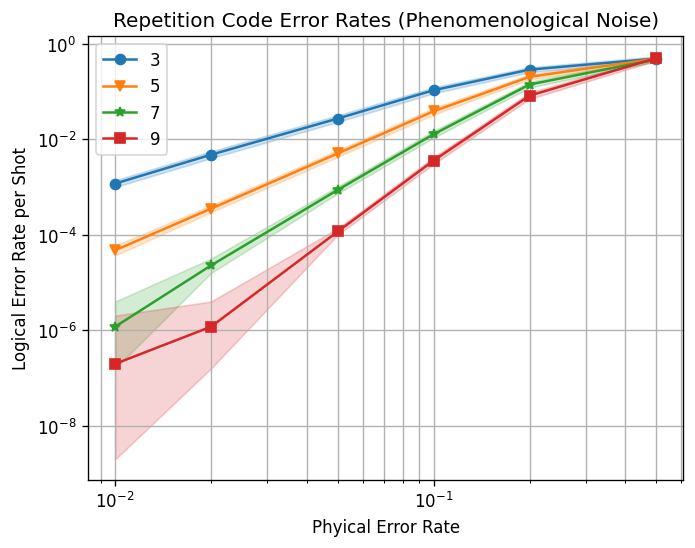

In [18]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
#ax.set_ylim(1e-4, 1e-0)
#ax.set_xlim(5e-2, 5e-1)
ax.loglog()
ax.set_title("Repetition Code Error Rates (Phenomenological Noise)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

ValueError: Failed to decompose errors into graphlike components with at most two symptoms.
The error component that failed to decompose is 'D310, D312, D315'.

In Python, you can ignore this error by passing `ignore_decomposition_failures=True` to `stim.Circuit.detector_error_model(...)`.
From the command line, you can ignore this error by passing the flag `--ignore_decomposition_failures` to `stim analyze_errors`.

Circuit stack trace:
    during TICK layer #145 of 169
    at instruction #76 [which is a REPEAT 19 block]

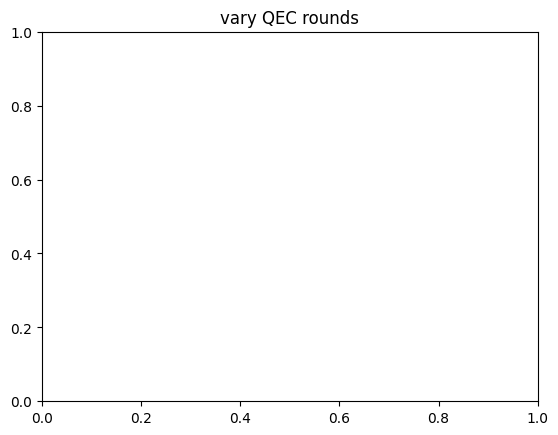

In [22]:
fig, ax = plt.subplots()
ax.set(title='vary QEC rounds')
num_shots = 100_000
for d in [7,5]:
    xs = [];   ys = []
    for x in [0.001, 0.002, 0.005, 0.01]:
        circuit = stim.Circuit.generated(
            'color_code:memory_xyz',
            #"repetition_code:memory",
            distance=d,
            rounds=d*3,
            before_round_data_depolarization=x,
        )
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(x)
        ys.append(num_errors_sampled / num_shots)
    ax.plot(xs, ys, label=f"QEC rounds={k}")
ax.plot([1e-3,1e-2],[1e-3,1e-2],'k--',label='y=x')
ax.set(xscale='log', yscale='log', xlabel="physical CX error", ylabel="logical error rate per shot")
ax.legend(); ax.grid()